In [1]:
!pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_DIR = os.path.join(REPO_DIR, "repo")
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)

def git_pull():
  ! (cd {REPO_DIR} && git pull )

git_pull()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=697d1c92e1f7c875e314d6b61fb36ce2cedc3e19ed98e21a4119e971d86cefd0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Unix-like
Mounted at /content/drive
Cloning into 'HeartRateRegression'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 1005 (delta 191), reused 148 (delta 76), pack-reused 719
Receiving objects: 100% (1005/1005), 88.37 MiB | 32.87 MiB/s, done.
Resolving deltas: 100% (647/647), done.
Already up to date.
Already up to date.


In [2]:
import random
import torch
from torch import nn
import numpy as np
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 128,     # Mini-batch size. 128
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

SEED = 1234
def reset_seeds():
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

reset_seeds()

cuda


In [3]:
!pip install heartpy

     |████████████████████████████████| 1.0MB 8.7MB/s 


In [4]:
from data_utils import (FormatPPGDalia, WesadExtractor)


SUBJECTS = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]

extractor = WesadExtractor(DATA_DIR)
ppg_dalia_formatter = FormatPPGDalia(from_ecg = True)
dfs_train = [ppg_dalia_formatter.transform(extractor.extract_subject(i)) for i in SUBJECTS]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:5216: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWa

In [5]:
git_pull()

import importlib

import PPG

from PPG import FullTrainer

importlib.reload(PPG.AttentionDefaults)
importlib.reload(PPG)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(PPG.Models)
importlib.reload(PPG.NoHrPceLstmModel)
importlib.reload(PPG.TrainerXY)
importlib.reload(PPG.TrainerIS)
importlib.reload(PPG.FullTrainer)


Already up to date.


<module 'PPG.FullTrainer' from '/tmp/HeartRateRegression/PPG/FullTrainer.py'>

In [ ]:
import matplotlib.pyplot as plt
import pickle
# fchoice = {'val_sub': 4,
#   'ts_sub': 0,
#   'batch_size': 64,
#   'weight_decay': 0,
#   'lr': 0.001,
#   'nattrs': 5,
#   'bvp_count': 16,
#   'dropout_rate': 0.25,
#   'lstm_input': 128,
#   'lstm_size': 64,
#   'ts_h_size': 64
#   }
def compute_ensemble(results):
  ps = [v["predictions"][1].reshape(-1).numpy() for v in results]
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]

  for i in range(1, len(ys)-1):
    assert np.all(ys[i] == ys[i-1])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  jps = np.stack(ps)
  eps = np.mean(np.abs(jps - y)) 

  plt.plot(a)
  plt.plot(y)

  return np.mean(np.abs(a - y)), eps


fchoice = {'val_sub': 4,
  'ts_sub': 0,
  'batch_size': 64,
  'weight_decay': 0.0001,
  'lr': 0.001,
  'nattrs': 5,
  'bvp_count': 12,
  'dropout_rate': 0,
  'lstm_input': 128,
  'lstm_size': 32,
  'ts_h_size': 32
  }



from PPG import UtilitiesDataXY
from collections import defaultdict

aresults = defaultdict(list)
for i in range(7):
  for ts_sub in [0,1,2,3, 4,5,6,7,8,9,10,11,12,13,14]:
    filename = f"wesad_ts_{ts_sub}_{i}_from_ecg_period2_.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = FullTrainer.JointValNoHrPceLstmFullTrainer(dfs_train, args["device"])
      try:
        fchoice["ts_sub"] = ts_sub
        out = full_trainer.train(**fchoice)
        
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub].append(out)
    
  # print(f"TS:{compute_ensemble(dresults)}")
  # aresults.append(dresults)


best val epoch: 1
[1/40]: loss_train: 12.018 loss_val 10.813 loss_ts 6.405
best val epoch: 2
[2/40]: loss_train: 11.553 loss_val 10.359 loss_ts 5.726
best val epoch: 3
[3/40]: loss_train: 10.562 loss_val 9.464 loss_ts 5.878
best val epoch: 4
[4/40]: loss_train: 9.001 loss_val 8.044 loss_ts 5.847
best val epoch: 5
[5/40]: loss_train: 8.446 loss_val 7.516 loss_ts 5.725
best val epoch: 6
[6/40]: loss_train: 8.203 loss_val 7.268 loss_ts 5.530
best val epoch: 7
[7/40]: loss_train: 7.554 loss_val 6.828 loss_ts 4.949
best val epoch: 8
[8/40]: loss_train: 6.899 loss_val 6.355 loss_ts 4.965
best val epoch: 9
[9/40]: loss_train: 6.525 loss_val 6.192 loss_ts 4.580
best val epoch: 10
[10/40]: loss_train: 5.804 loss_val 5.751 loss_ts 4.880
best val epoch: 11
[11/40]: loss_train: 5.860 loss_val 5.632 loss_ts 4.242
best val epoch: 12
[12/40]: loss_train: 5.593 loss_val 5.602 loss_ts 4.563
best val epoch: 13
[13/40]: loss_train: 5.125 loss_val 5.279 loss_ts 4.404
best val epoch: 14
[14/40]: loss_train

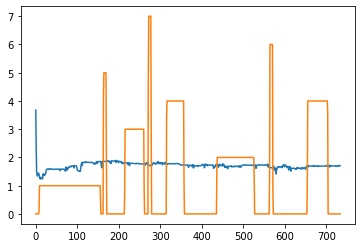

In [ ]:

def compute_ensemble(results):
  ps = [v["predictions"][1].reshape(-1).numpy() for v in results]
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]

  for i in range(1, len(ys)-1):
    assert np.all(ys[i] == ys[i-1])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.plot(a)
  plt.plot(y)

  np.mean(np.abs(a - y))

compute_ensemble(dresults)

# import matplotlib.pyplot as plt


# p = p.reshape(-1)

# plt.plot(y)
# plt.plot(p)


In [ ]:
import random 
options = {
  "ts_h_size": [64, 128],
  "lstm_size": [64, 64, 128],
  "lstm_input": [64, 128, 256],
  "dropout_rate": [0.25],
  "bvp_count": [8,16],
  "nattrs": [5],
  'lr': [0.001],
  'weight_decay': [0, 0.0001],
  'batch_size': [64, 128, 256],
  'ts_sub': [0],
  'val_sub': [4]
 }

def choose(options):
  choice = dict()
  for k,v in options.items():
    choice[k] = random.choice(v)
  return choice


In [ ]:
results = list()
from PPG import UtilitiesDataXY
while True:
  full_trainer = FullTrainer.NoHrPceLstmFullTrainer(dfs_train, args["device"])
  choice = choose(options)
  try:
    out = full_trainer.train(**choice)
    print(out["args"], out["metric"])
    results.append([out["args"], out["metric"]])
  except RuntimeError as e:
    if isinstance(e, KeyboardInterrupt):
      raise e
    else:
      print("####")
      print(f"Failed: {choice}")
      print("###")

best val epoch: 9
[9/30]: loss_train: 9.627 loss_val 4.573 loss_ts 5.796


KeyboardInterrupt: ignored

In [ ]:
results

In [ ]:
fchoice = {'val_sub': 4,
  'ts_sub': 0,
  'batch_size': 64,
  'weight_decay': 0,
  'lr': 0.001,
  'nattrs': 5,
  'bvp_count': 16,
  'dropout_rate': 0.25,
  'lstm_input': 128,
  'lstm_size': 64,
  'ts_h_size': 64}


dresults = list()
from PPG import UtilitiesDataXY
ts_sub = 3
for val_sub in [i for i in range(15) if i != ts_sub]:
  full_trainer = FullTrainer.NoHrPceLstmFullTrainer(dfs_train, args["device"])
  try:
    fchoice["ts_sub"] = ts_sub
    fchoice["val_sub"] = val_sub
    out = full_trainer.train(**fchoice)
    print(out["args"], out["metric"])
    dresults.append([out])
  except RuntimeError as e:
    if isinstance(e, KeyboardInterrupt):
      raise e
    else:
      print("####")
      print(f"Failed: {choice}")
      print("###")

In [ ]:
y = 

In [ ]:
full_trainer = FullTrainer.AttentionFullTrainer(dfs_train, args["device"], 0, 1)

full_trainer.train()

In [ ]:
from PPG import UtilitiesDataXY 


transformers = PPG.AttentionDefaults.get_preprocessing_transformer()
make_loaders = UtilitiesDataXY.DataLoaderFactory(transformers, dfs_train).make_loaders

loader_tr, loader_val, loader_ts = make_loaders(ts_sub=0, val_sub=1)

In [ ]:
from PPG.Models import SnippetConvolutionalTransformer

net = SnippetConvolutionalTransformer().to(args["device"])

# x,y = next(iter(loader_tr))

# p = net(x)

criterion = nn.MSELoss().to(args["device"])# nn.L1Loss().to(args["device"]) #nn.CrossEntropyLoss().to(args["device"])
optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                             weight_decay=args["weight_decay"])


In [ ]:
from PPG.TrainerXY import (EpochTrainerXY, MetricsComputerXY, TrainHelperXY)
from preprocessing_utils import ZTransformer2

epoch_trainer = EpochTrainerXY(net, optimizer, criterion, args["device"])
ztransformer = ZTransformer2(['heart_rate', 'wrist-ACC-0', 'wrist-ACC-1', 'wrist-ACC-2',
              'wrist-BVP-0', 'wrist-EDA-0', 'wrist-TEMP-0', 'chest-ACC-0',
              'chest-ACC-1', 'chest-ACC-2', 'chest-Resp-0'])
metrics_comuter = MetricsComputerXY(ztransformer)

train_helper = TrainHelperXY(epoch_trainer, loader_tr, loader_val, loader_ts, metrics_comuter.mae)

In [ ]:
train_helper.train(30)